# Importing and downloading useful Libraries

In [0]:
!pip install torch>=1.2.0
!pip install torchaudio

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from sklearn.metrics import f1_score

from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm 
import math, copy, time,os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the Data loader script

In [0]:
from data_loader import loader 

# Emptying anything cached in the memory, though not necessary for colab, it is a good measure for rest of the gpus

In [0]:
torch.cuda.empty_cache() 

# Loading the Data

In [0]:
train_src = '/content/drive/My Drive/NLP /emotion/meld/train'
val_src = '/content/drive/My Drive/NLP /emotion/meld/val'

In [8]:
train_data, val_data, test_data = loader(train_src, val_src, 10)

# All of the intuition behind the models implemented below are written in the Readme included in the GitHub repository 

# Defining the GRU model 
Here I define a standard GRU (zero hidden layer initialization) class using inheritance from Pytorch. 

In [0]:
class RNNModel(nn.Module):
    def __init__(self, output_dim, n_mfcc, hid_dim, dropout = 0.5):
        super().__init__()
        self.rnn = nn.GRU(n_mfcc, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # print(src.size())
        src = src.permute(1,0,2)
        output, hidden = self.rnn(src)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out = self.fc(hidden.squeeze())
        return out

In [0]:
output_dim  =  5
n_mfcc = 40
hid_dim = 100 

model = RNNModel(output_dim, n_mfcc , hid_dim ,dropout = 0.5).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-5)
criterion = nn.BCEWithLogitsLoss().cuda()

# Defining the LSTM model
Using the above code as a skeleton code

In [0]:
class LSTMModel(nn.Module):
    def __init__(self, output_dim, n_mfcc, hid_dim, dropout = 0.5):
        super().__init__()
        self.rnn = nn.LSTM(n_mfcc, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # print(src.size())
        src = src.permute(1,0,2)
        output, (hidden, c_n) = self.rnn(src)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out = self.fc(hidden.squeeze())
        return out

In [0]:
output_dim  =  5
n_mfcc = 40
hid_dim = 100 

model = LSTMModel(output_dim, n_mfcc , hid_dim ,dropout = 0.5).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-5)
criterion = nn.BCEWithLogitsLoss().cuda()

# Defining the CNN model 
The model defined below is the implementation of the model used in kim Y. et Al. (2014). I have modified the model to take mfcc features as the input instead of word-ids as used in the paper. 

In [0]:
class CNNmodel(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super(CNNmodel, self).__init__()
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = x.unsqueeze(1)
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        out = self.linear(out)
        return out 

In [0]:
n_mfcc = 40
n_filters = 100
filter_sizes = [3,4,5]
output_dim = 5
dropout = 0.5

model = CNNmodel(n_mfcc, n_filters , filter_sizes, output_dim ,dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-5)
criterion = nn.BCEWithLogitsLoss().cuda()
# criterion = nn.CrossEntropyLoss().cuda()

# Defining the Ensemble model for GRU+CNN 
Here we concatenate the final hidden layer of the GRU and the final layer (concatenated max-pooled layers) of the CNN, and pass it through a MLP consisting of a max-pool layer and a linear layer. 

In [0]:
class RNN(nn.Module):
    def __init__(self, output_dim, n_mfcc, hid_dim, dropout = 0.5):
        super().__init__()
        self.rnn = nn.GRU(n_mfcc, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.hid_dim = 2*hid_dim 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # print(src.size())
        src = src.permute(1,0,2)
        output, hidden = self.rnn(src)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return hidden

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super(CNN, self).__init__()
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.len_layer = len(filter_sizes)*n_filters
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        # embedded = self.embedding(x) #o/p->[batch size, sent len, emb dim]
        embedded = x.unsqueeze(1)#o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        return out 


class RNN_CNNmodel(nn.Module):
    def __init__(self, cnn, rnn, output_dim, dropout):
        super().__init__()
        self.cnn = cnn
        self.rnn = rnn 
        self.fc1 = nn.Linear(cnn.len_layer + rnn.hid_dim, 100)
        self.maxpool = nn.MaxPool1d(2)
        self.fc2 = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out1 = self.cnn(x)
        out2 = self.rnn(x)
        out = torch.cat((out1,out2), dim = 1)
        out = self.fc1(out)
        out = out.unsqueeze(0)
        out = self.maxpool(out)
        out = out.squeeze()
        out = self.fc2(out)
        return out

In [0]:
n_mfcc = 40
n_filters = 100
filter_sizes = [3,4,5]
output_dim = 5
dropout = 0.5

cnn = CNN(n_mfcc, n_filters , filter_sizes, output_dim ,dropout).cuda()

output_dim  =  5
n_mfcc = 40
hid_dim = 100 

rnn = RNN(output_dim, n_mfcc , hid_dim ,dropout = 0.5).cuda()

model = RNN_CNNmodel(cnn, rnn, 5, dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-5)
criterion = nn.BCEWithLogitsLoss().cuda()

# Defining the Ensemble model for GRU+LSTM 
We take the final hidden layer of both GRU and LSTM and concatenate it, then we pass it through a MLP consisting of 2 linear layers.  


In [0]:
class LSTM(nn.Module):
    def __init__(self, output_dim, n_mfcc, hid_dim, dropout = 0.5):
        super().__init__()
        self.rnn = nn.LSTM(n_mfcc, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.hid_dim = 2*hid_dim
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # print(src.size())
        src = src.permute(1,0,2)
        output, (hidden, c_n) = self.rnn(src)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return hidden

class RNN(nn.Module):
    def __init__(self, output_dim, n_mfcc, hid_dim, dropout = 0.5):
        super().__init__()
        self.rnn = nn.GRU(n_mfcc, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.hid_dim = 2*hid_dim 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # print(src.size())
        src = src.permute(1,0,2)
        output, hidden = self.rnn(src)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return hidden

class RNN_LSTMmodel(nn.Module):
    def __init__(self, lstm, rnn, output_dim, dropout):
        super().__init__()
        self.lstm = lstm
        self.rnn = rnn 
        self.fc1 = nn.Linear(lstm.hid_dim + rnn.hid_dim, 100)
        self.fc2 = nn.Linear(100, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out1 = self.lstm(x)
        out2 = self.rnn(x)
        out = torch.cat((out1,out2), dim = 1)
        out = self.fc1(out)
        # out = out.unsqueeze(0)
        # out = out.squeeze()
        out = self.fc2(out)
        return out

In [0]:
output_dim  =  5
n_mfcc = 40
hid_dim = 100 

rnn = RNN(output_dim, n_mfcc , hid_dim ,dropout = 0.5).cuda()

output_dim  =  5
n_mfcc = 40
hid_dim = 100 

lstm = LSTM(output_dim, n_mfcc , hid_dim ,dropout = 0.5).cuda()

model = RNN_LSTMmodel(lstm, rnn, 5, dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
criterion = nn.BCEWithLogitsLoss().cuda()

# Defining the trainer function 
This function takes in the model and the dataset and trains, predicts and calculates the accuracy on the dataset. 

It outputs the accuracy for all three sets (test, val, train) and the confusion matrix for val and test sets. 

We save the best model on basis of the val loss. 

In [0]:
def evaluate(model, test_data, test = 0):
  model.eval()
  denom = 0.0
  numer = 0.0
  y_true = [] 
  y_pred = []
  with torch.no_grad():
    for batch in test_data:
      trg = Variable(batch['label_one_hot']).cuda()
      src = Variable(batch['mfcc2']).cuda()
      out = model(src)
      out = out.squeeze() 
      out = out.data 
      trg = trg.data 
      _,trg1 = torch.max(trg, dim = 1)
      _,out1 = torch.max(out, dim = 1)
      trg1 = trg1.data.cpu().numpy() 
      out1 = out1.data.cpu().numpy() 
      denom += len(trg1)
      for i in range(len(trg1)):
        if(trg1[i] == out1[i]):
          numer += 1
      y_true.extend(trg1.tolist())
      y_pred.extend(out1.tolist())
    
    if(test):
      labels = [0,1,2,3,4]
      conf = confusion_matrix(y_true, y_pred, labels = labels)
      df_cm = pd.DataFrame(conf, index = labels, columns = labels)
      plt.figure(figsize = (10,7))
      plt.title('Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      sns.heatmap(df_cm.astype(int) , annot=True,cmap="Blues",fmt='g')
      
  return (float(numer)/float(denom))*100

def trainer(model,train_data,val_data,test_data, optimizer, criterion, epochs):
  running_loss = []
  val_loss = []
  running_epochs  = []
  train_accuracy = []
  val_accuracy = []
  best_loss = math.inf
  best_model_state_dict = {k:v for k, v in model.state_dict().items()}
  best_model_state_dict = OrderedDict(best_model_state_dict)
  MODEL_DIR = '/content/drive/My Drive/NLP /emotion/meld'
  MODEL_DIR = os.path.join(MODEL_DIR, 'emotion_model_gru_cnn.pt')
  for epoch in tqdm(range(epochs)):  
    epoch_loss = 0 
    epoch_acc = 0
    epoch_size = 0
    
    model.train()
    
    for batch in tqdm(train_data):
        optimizer.zero_grad()
        src = Variable(batch['mfcc2']).cuda()
        out = model(src)
        out = out.squeeze()
        trg = Variable(batch['label_one_hot']).cuda()
        loss = criterion(out, trg)
        loss.backward()    
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    model.eval()
    
    train_accuracy.append(evaluate(model, train_data))
    running_loss.append(epoch_loss/len(train_data))
    running_epochs.append(epoch+1)
    epoch_loss = 0
    
    with torch.no_grad():
      for batch in tqdm(val_data):
          src = Variable(batch['mfcc2']).cuda()
          out = model(src)
          out = out.squeeze()
          trg = Variable(batch['label_one_hot']).cuda()
          loss = criterion(out, trg)
          epoch_loss += loss.item()

    val_accuracy.append(evaluate(model, val_data))
    val_loss.append(epoch_loss/len(val_data))
    curr_loss = epoch_loss/len(val_data)
    if(curr_loss < best_loss):
      best_loss = curr_loss
      torch.save(model.state_dict(), MODEL_DIR) 
      best_model_state_dict = {k:v for k, v in model.state_dict().items()}
      best_model_state_dict = OrderedDict(best_model_state_dict)
    
  fig= plt.figure(figsize=(20,10))
  plt.plot(np.array(running_epochs), np.array(running_loss), 'b', label='Training loss')
  plt.plot(np.array(running_epochs), np.array(val_loss), 'g', label = 'validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
  fig= plt.figure(figsize=(20,10))
  plt.plot(np.array(running_epochs), np.array(train_accuracy), 'b', label='Training accuracy')
  plt.plot(np.array(running_epochs), np.array(val_accuracy), 'g', label = 'validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
  model.load_state_dict(torch.load(MODEL_DIR))
  print("Accuracy of the Model on Train Data :",evaluate(model, train_data))
  print("Accuracy of the Model on Validation Data :",evaluate(model, val_data,1))
  print("Accuracy of the Model on Test Data :",evaluate(model, test_data, 1))

In [0]:
trainer(model, train_data, val_data,test_data, optimizer, criterion, 15)

# Final Testing 
Note - The output might differ slightly from the one specified in the Readme, as the seed isn't specified, even so the difference should be in the acceptable range. 

Accuracy of the Model on Validation Data : 42.89156626506024


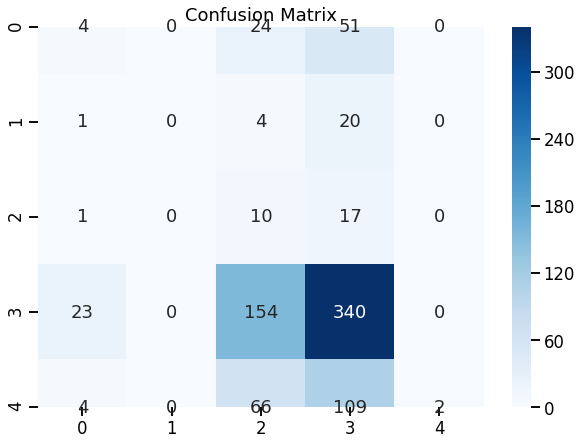

In [73]:
MODEL_DIR = '/content/drive/My Drive/NLP /emotion/meld'
MODEL_DIR = os.path.join(MODEL_DIR, 'emotion_model_gru_lstm.pt')
model.load_state_dict(torch.load(MODEL_DIR))
print("Accuracy of the Model on Validation Data :",evaluate(model, val_data,1))